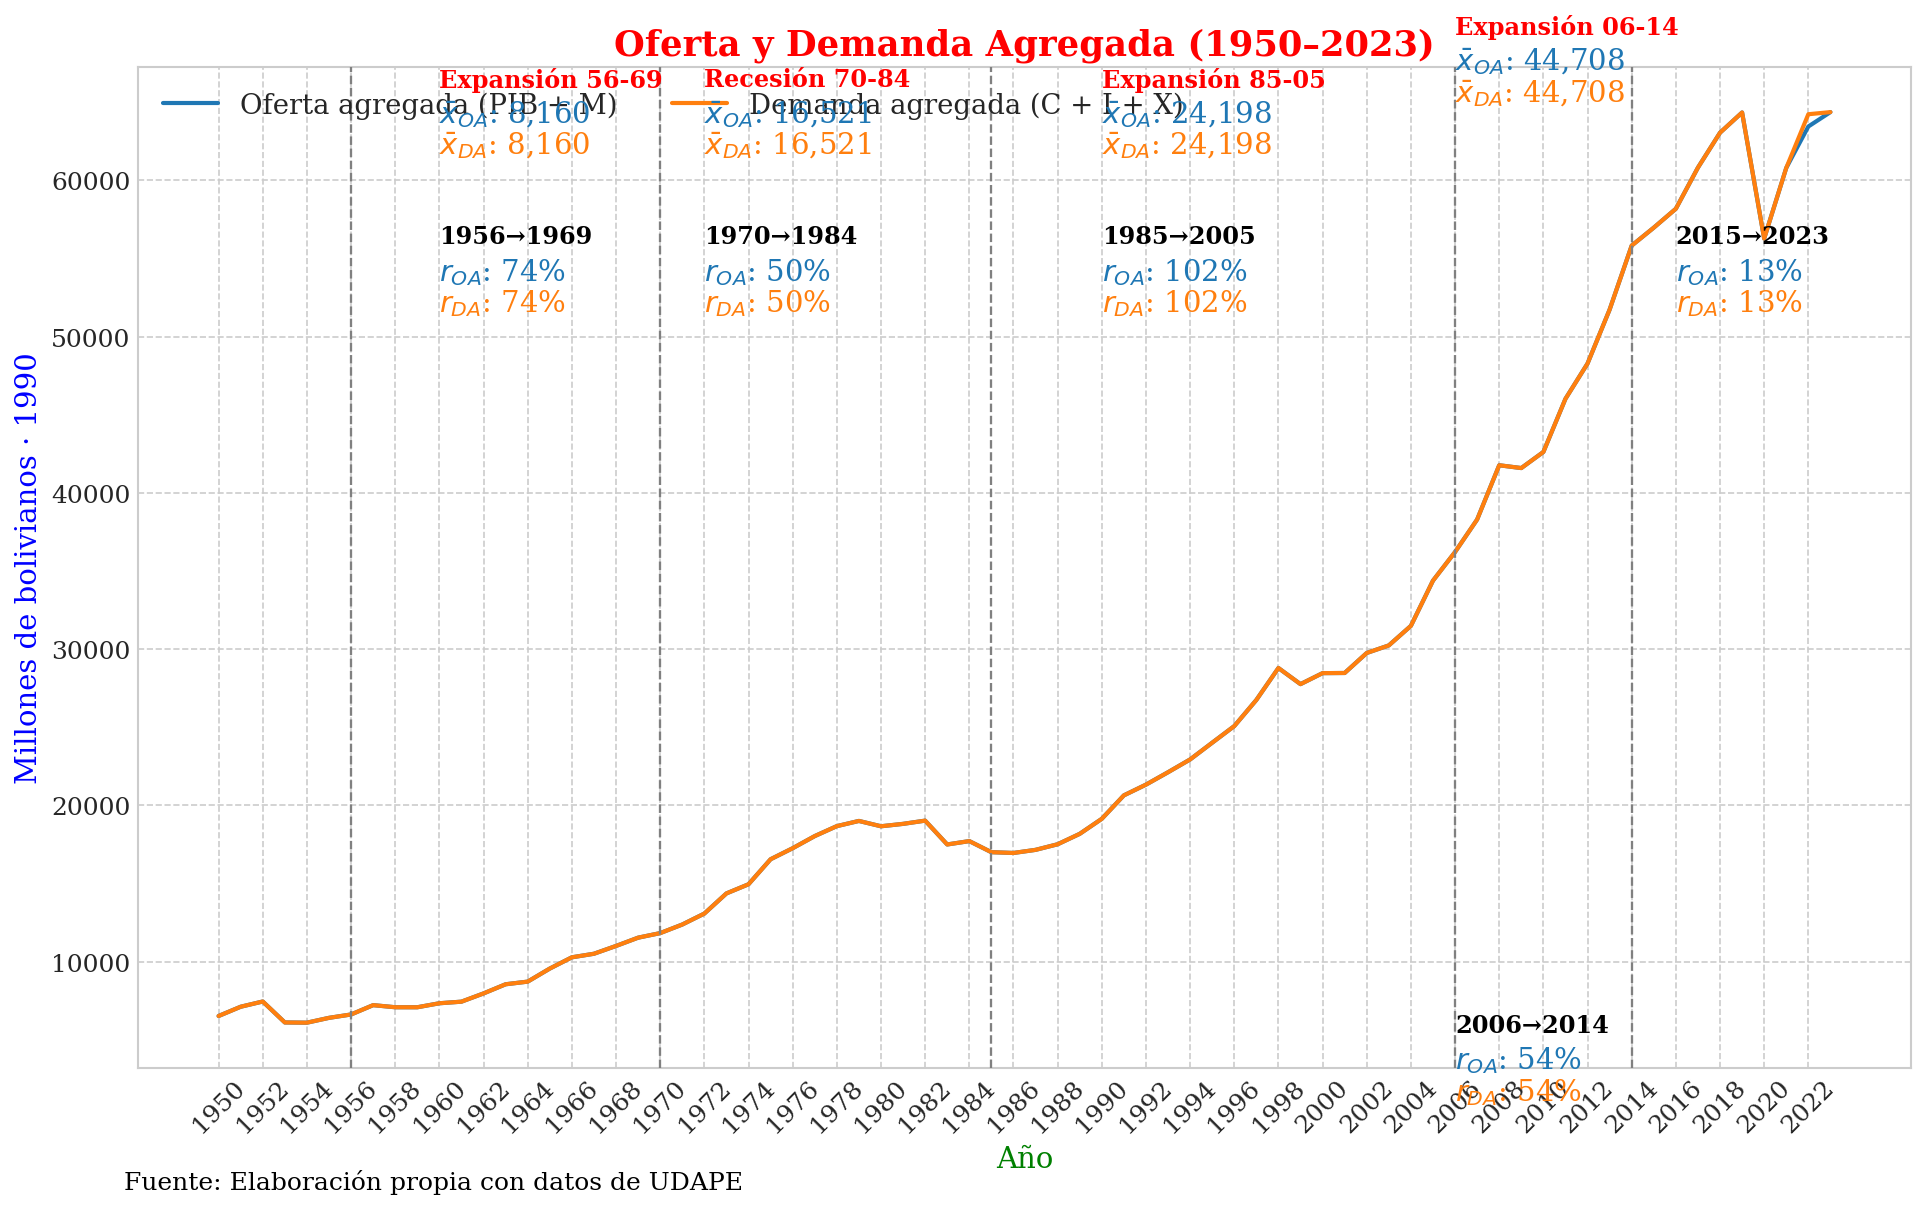

In [3]:
# ─────────────────────────────────────────────────────────────────────
# OA-DA  ‖  Oferta vs Demanda Agregada (1950-2023)
# Estructura 100 % alineada a la plantilla de “Estructura Graficas.pdf”
# ─────────────────────────────────────────────────────────────────────
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
# utilidades y constantes corporativas

from func_auxiliares.graficos_utils import (
    set_style, init_base_plot,
    add_hitos, add_year_value_annotations,
    add_cycle_means_multi, add_period_growth_annotations_multi,
    adjust_annot_years, adjust_cycles, adjust_periods
)
from func_auxiliares.config import (
    ASSETS_DIR, DB_PATH,                                   # rutas
    CYCLES_SIN_CRISIS, hitos_v_sin_crisis,                 # ciclos “sin crisis”
    annot_years_sin_crisis, periodos_tasas_sin_crisis,
)

# ─────────────────────────────────────────────────────────────
# 1. Configuración global
# ─────────────────────────────────────────────────────────────
output_dir = ASSETS_DIR / "serie_completa" / "oa_da"
output_dir.mkdir(parents=True, exist_ok=True)
set_style()

# ─────────────────────────────────────────────────────────────
# 2. Carga de datos y cálculo de OA, DA
# ─────────────────────────────────────────────────────────────
with sqlite3.connect(DB_PATH) as conn:
    df = (
        pd.read_sql(
            """
            SELECT año,
                   gastos_consumo,
                   formacion_capital,
                   exportacion_bienes_servicios,
                   importacion_bienes,
                   pib_real_base_1990
            FROM pib_real_gasto
            """,
            conn,
            index_col="año"
        )
        .sort_index()
        / 1000                   # → millones de Bs 1990
    )

# variables agregadas
df["OA"] = df["pib_real_base_1990"] + df["importacion_bienes"]              # PIB + M
df["DA"] = (
    df["gastos_consumo"] + df["formacion_capital"] + df["exportacion_bienes_servicios"]
)                                                                           # C + I + X

# ─────────────────────────────────────────────────────────────
# 3. Componentes, abreviaturas y colores
# ─────────────────────────────────────────────────────────────
componentes = [
    ("OA", "Oferta agregada (PIB + M)"),
    ("DA", "Demanda agregada (C + I + X)"),
]
cols_componentes = [c for c, _ in componentes]

colors = {
    "OA": "#1f77b4",   # azul
    "DA": "#ff7f0e",   # naranja
}
abbr = {"OA": "OA", "DA": "DA"}

# ─────────────────────────────────────────────────────────────
# 4. Preparación de ciclos, periodos y años a anotar
# ─────────────────────────────────────────────────────────────
annot_years   = adjust_annot_years(df, annot_years_sin_crisis)
cycles        = adjust_cycles(df, CYCLES_SIN_CRISIS)
cycle_stats   = {n: df.loc[s, cols_componentes].mean().to_dict()
                 for n, s in cycles.items()}
periodos      = adjust_periods(df, periodos_tasas_sin_crisis)

# ─────────────────────────────────────────────────────────────
# 5. Offsets (vacíos para que los ajustes después)
# ─────────────────────────────────────────────────────────────
annotation_offsets = {
    "OA": {},   # Añade (año: (dx, dy)) cuando ajustes maqueta
    "DA": {},
}
hitos_offset   = {a: 0.82 for a in hitos_v_sin_crisis}          # texto ≈82 % de alto
medias_offsets = {
    "Expansión 56-69": (1960, 1.00),
    "Recesión 70-84":  (1972, 1.00),
    "Expansión 85-05": (1990, 1.00),
    "Expansión 06-14": (2006, 1.05),
    "Recesión 15-24":  (2016, 1.05),
}
tasas_offsets  = {
    "1956-1969": (1960, 0.85),
    "1970-1984": (1972, 0.85),
    "1985-2005": (1990, 0.85),
    "2006-2014": (2006, 0.10),
    "2015-2023": (2016, 0.85),
}

# ─────────────────────────────────────────────────────────────
# 6. Gráfica
# ─────────────────────────────────────────────────────────────
fig, ax = init_base_plot(
    df,
    series=componentes,
    colors=colors,
    title=f"Oferta y Demanda Agregada ({df.index.min()}–{df.index.max()})",
    xlabel="Año",
    ylabel="Millones de bolivianos · 1990",
    source_text="Fuente: Elaboración propia con datos de UDAPE"
)

add_hitos(ax, df.index, hitos_v_sin_crisis, hitos_offset)
add_year_value_annotations(
    ax, df, annot_years,
    cols_componentes, annotation_offsets, colors
)

# Bloques de medias por ciclo
y_max = ax.get_ylim()[1]
line_spacing = y_max * 0.03
add_cycle_means_multi(
    ax, cycle_stats, medias_offsets,
    abbr, colors, line_spacing
)

# Tasas de crecimiento OA, DA por periodo
add_period_growth_annotations_multi(
    ax, df, periodos,
    cols_componentes, tasas_offsets,
    colors, abbr
)

# Guardar
#plt.savefig(output_dir / "oa_da.png")
plt.show()


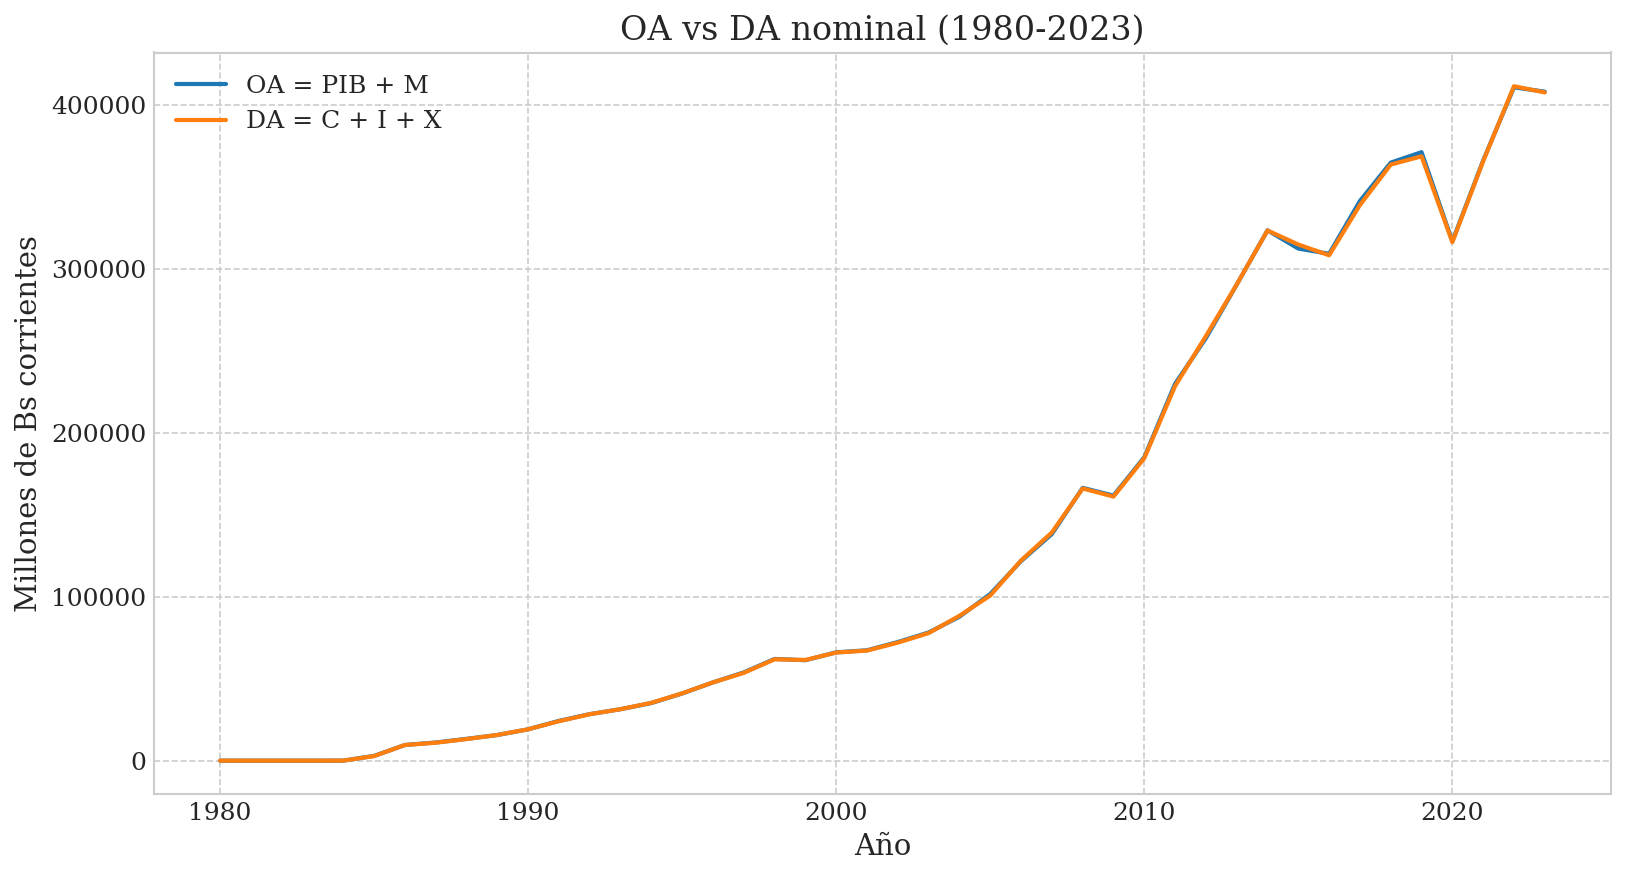

In [6]:


DB = "../../../../db/proyectomacro.db"      # ajusta si tu ruta difiere

# 1. Cargar variables nominales (1980-2023)
with sqlite3.connect(DB) as conn:
    df_2 = (
        pd.read_sql(
            """
            SELECT año,
                   pib_a_precios_corrientes      AS pib_nom,
                   gastos_consumo                AS C_nom,
                   formacion_capital             AS I_nom,
                   exportacion_bienes_servicios  AS X_nom,
                   importacion_bienes            AS M_nom
            FROM pib_nominal_gasto
            """,
            conn,
            index_col="año"
        )
        .sort_index()
    )

# 2. Construir OA y DA nominales  (en miles de Bs corrientes)
df_2["OA_nom"] = df_2["pib_nom"] + df_2["M_nom"]      # PIB + M
df_2["DA_nom"] = df_2["C_nom"] + df_2["I_nom"] + df_2["X_nom"]   # C + I + X

# 3. Pasar a **millones** (opcional, solo escala)
df_2[["OA_nom","DA_nom"]] = df_2[["OA_nom","DA_nom"]] / 1_000

# 4. Graficar en una sola línea
ax = df[["OA_nom","DA_nom"]].plot(
        figsize=(11,6),
        title="OA vs DA nominal (1980-2023)",
        xlabel="Año",
        ylabel="Millones de Bs corrientes",
        lw=2
     )
ax.legend(["OA = PIB + M", "DA = C + I + X"])
plt.tight_layout()
plt.show()


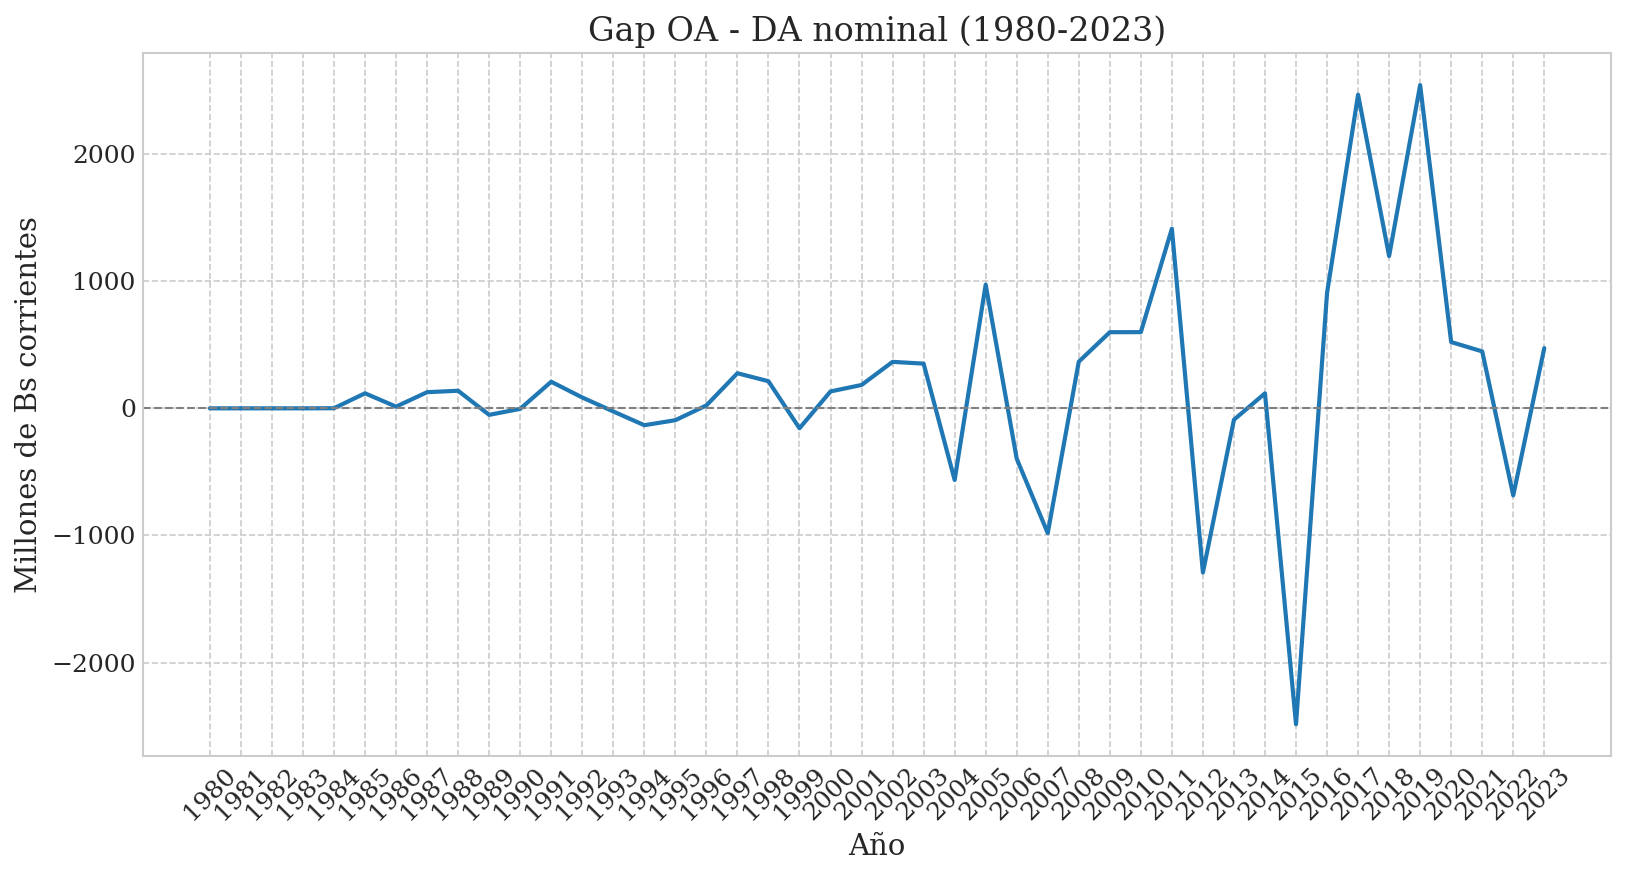

In [10]:
df_2['gap']=df_2['OA_nom']-df_2['DA_nom']
#grafica df_gap
ax = df_2['gap'].plot(
        figsize=(11,6),
        title="Gap OA - DA nominal (1980-2023)",
        xlabel="Año",
        ylabel="Millones de Bs corrientes",
        lw=2
     )
plt.axhline(0, color='gray', lw=1, ls='--')
#x ticks anual
plt.xticks(df_2.index, rotation=45)
plt.tight_layout()
plt.show()

α (gasto autónomo)  = -718 mill. Bs
β (PMC estimada)    = 1.33


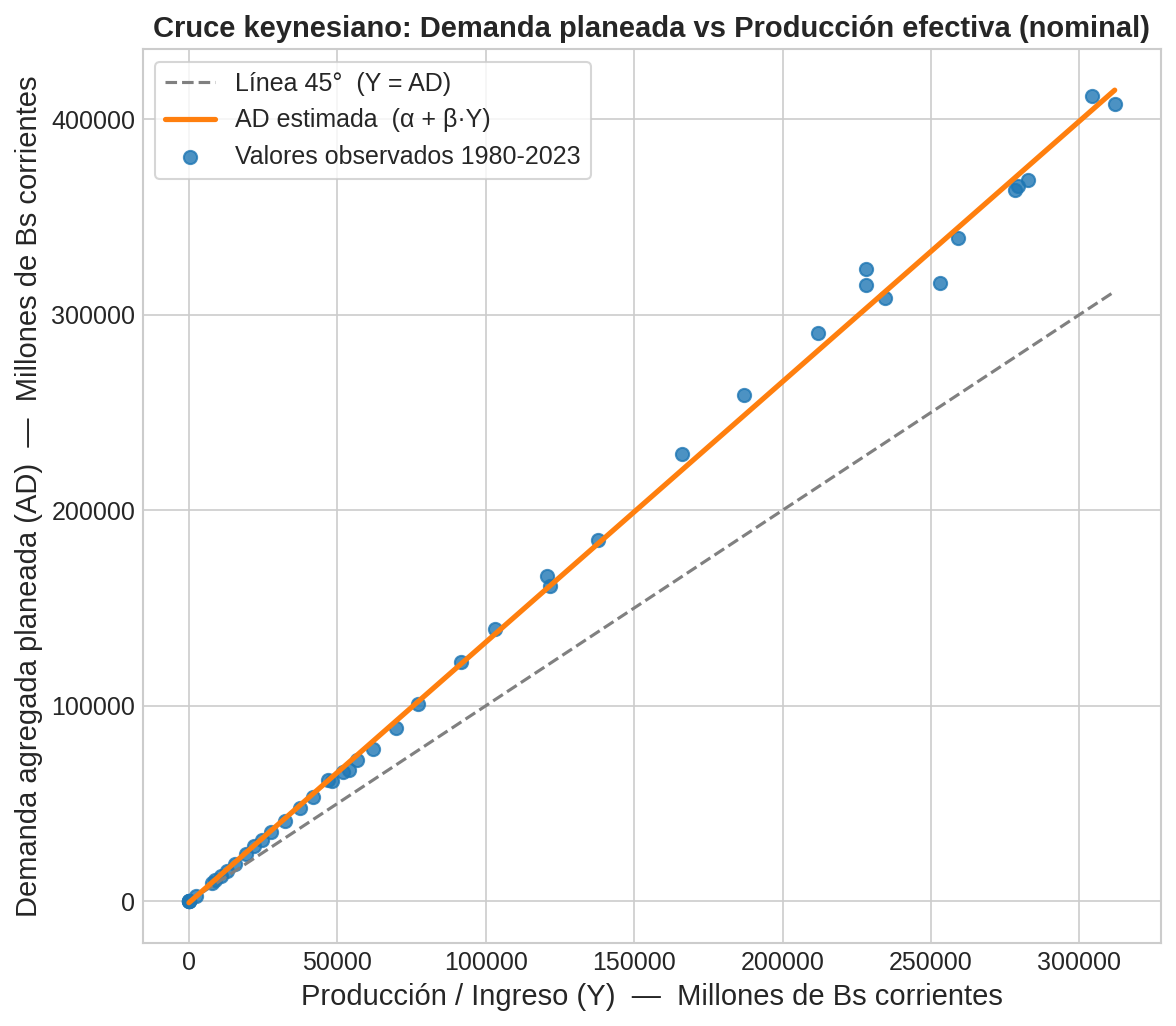

In [12]:
# ─────────────────────────────────────────────────────────────────────
# Cruce keynesiano (AD vs Y) con datos nominales de Bolivia, 1980-2023
# ─────────────────────────────────────────────────────────────────────
import os, sys, sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ▸ Ajusta esto si tu proyecto tiene rutas distintas
DB = "../../../../db/proyectomacro.db"

# 1) ─── Carga de datos ───────────────────────────────────────────────
with sqlite3.connect(DB) as conn:
    df = (
        pd.read_sql(
            """
            SELECT año,
                   pib_a_precios_corrientes            AS Y,
                   consumo_privado                     AS C_priv,
                   consumo_publico                     AS G,
                   formacion_capital                   AS I,
                   exportacion_bienes_servicios        AS X
            FROM pib_nominal_gasto
            """,
            conn,
            index_col="año"
        )
        .sort_index()
        / 1000      # ⇒ millones de Bs corrientes
    )

# 2) ─── Demanda agregada planeada (AD) ───────────────────────────────
df["AD"] = df["C_priv"] + df["I"] + df["G"] + df["X"]

# 3) ─── Ajuste lineal AD = α + β Y  (OLS rápido con numpy) ───────────
β, α = np.polyfit(df["Y"], df["AD"], 1)      # AD = α + β·Y
Y_min, Y_max = df["Y"].min(), df["Y"].max()
Y_grid = np.linspace(Y_min, Y_max, 100)
AD_hat = α + β * Y_grid

print(f"α (gasto autónomo)  = {α:,.0f} mill. Bs")
print(f"β (PMC estimada)    = {β:.2f}")

# 4) ─── Gráfico del cruce keynesiano ─────────────────────────────────
plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(8,7))

# Línea 45°  → OA ex post
ax.plot([Y_min, Y_max], [Y_min, Y_max],
        color="gray", linestyle="--", linewidth=1.5,
        label="Línea 45°  (Y = AD)")

# Línea AD estimada ex ante
ax.plot(Y_grid, AD_hat, color="#ff7f0e", linewidth=2.5,
        label=f"AD estimada  (α + β·Y)")

# Puntos empíricos por año
ax.scatter(df["Y"], df["AD"], color="#1f77b4", s=40, alpha=0.8,
           label="Valores observados 1980-2023")

# Etiquetas y título
ax.set_title("Cruce keynesiano: Demanda planeada vs Producción efectiva (nominal)",
             fontsize=14, fontweight="bold")
ax.set_xlabel("Producción / Ingreso (Y)  —  Millones de Bs corrientes")
ax.set_ylabel("Demanda agregada planeada (AD)  —  Millones de Bs corrientes")
ax.legend(frameon=True)
plt.tight_layout()
plt.show()
